# Bradley-Terry Modeling of Players in Super Smash Brothers Melee

In this notebook we'll analyze two decades of Smash Melee matches released in the [EsportsBench dataset](https://huggingface.co/datasets/EsportsBench/EsportsBench). We'll compare the ranking produced by this automatic data-driven method to those produced by panels of human experts.

Steps:
1. Download and process the dataset.
2. Compute ratings and confidence intervals using Arena-Rank.
3. Analyze the leaderboards for each year from 2005-2024.

In [1]:
import datasets
import pandas as pd

from arena_rank.utils.data_utils import PairDataset
from arena_rank.models.bradley_terry import BradleyTerry

from example_utils import (
    plot_melee_bump_chart,
    filter_melee_matches,
    filter_melee_leaderboard,
    convert_ssbmrank_dict_to_plotting_df,
)

pd.set_option("display.width", 1000)
pd.set_option("display.max_columns", None)

### Dataset
For this analysis we only need the date, the two competitors, and a column representing the winner. The `outcome` column is 1.0 if the player in the `competitor_1` column won and 
0.0 if the player in `competitor_2` won.


In [2]:
df = datasets.load_dataset(
    "EsportsBench/EsportsBench", split="smash_melee", columns=["date", "competitor_1", "competitor_2", "outcome"]
).to_pandas()
df["date"] = pd.to_datetime(df["date"])
df

,date,competitor_1,competitor_2,outcome
0,2004-01-10,Azen,Chillindude,1.0
1,2004-01-10,Isai,Wes,1.0
2,2004-01-10,Azen,Isai,1.0
3,2004-01-10,Jason,Ken (Melee player),0.0
4,2004-01-10,Dave,Sultan of Samitude,1.0
...,...,...,...,...
414804,2025-09-07,Rick,NSFrog,1.0
414805,2025-09-07,Inky,Squid,1.0
414806,2025-09-07,KELLZ,Rick,1.0
414807,2025-09-07,Squid,KELLZ,1.0


### Modeling
To compute the leaderboard, first we need to create a `PairDataset` object from the dataframe, specifying the columns we created, and how the values of the "winner" column map to outcomes.
Then we can create the `BradleyTerry` model object and fit it on the dataset.

When fitting leaderboards to data for each year, we apply several filtering heuristics, such as setting a minimum number of matches played and the number of unique opponents. The Bradley-Terry model can break down if there are disconnected sets of competitors or if there are competitors with only wins or only losses. The Melee has many small, local tournaments and these situations arise a lot.

In [3]:
def compute_leaderboard(df):
    dataset = PairDataset.from_pandas(
        df,
        competitor_cols=["competitor_1", "competitor_2"],
        outcome_col="outcome",
        outcome_map=lambda x: x,  # these are already in the required format
    )
    model = BradleyTerry(
        n_competitors=dataset.n_competitors,
        init_rating=1000,
    )
    model.fit(dataset)
    counts = df[["competitor_1", "competitor_2"]].stack().value_counts()
    leaderboard_df = pd.DataFrame(
        {
            "Competitor": dataset.competitors,
            "Rating": model.params["ratings"],
            "Matches Played": counts[dataset.competitors].values,
        }
    )
    leaderboard_df = leaderboard_df.sort_values(by="Rating", ascending=False).reset_index(drop=True)
    return leaderboard_df

In [4]:
all_results = []
for year in range(2005, 2025):
    start_date = pd.Timestamp(f"{year}-01-01")
    end_date = pd.Timestamp(f"{year}-12-31")
    df_year = df[(df["date"] >= start_date) & (df["date"] <= end_date)]
    df_year = filter_melee_matches(df_year)
    leaderboard_df = compute_leaderboard(df_year)
    filtered_leaderboard_df = filter_melee_leaderboard(leaderboard_df, df_year)
    start_date = end_date + pd.Timedelta(days=1)
    filtered_leaderboard_df["Year"] = year
    all_results.append(filtered_leaderboard_df)

### Visualization
We can take the top 5 players from each year's leaderboard and plot them over time to see how the pool of top player has evolved.

We can immediately see the era of the [Five Gods](https://liquipedia.net/smash/Five_Gods). From 2009 to 2017, at least 4 of the 5 top players are from the set of Mew2King, Mang0, Armada, Hungrybox and PPMD. And Mew2King was present in the top 5 all the way from 2006 to 2018. The end of that era plus the Covid interruption has led to a very different set of top players. 

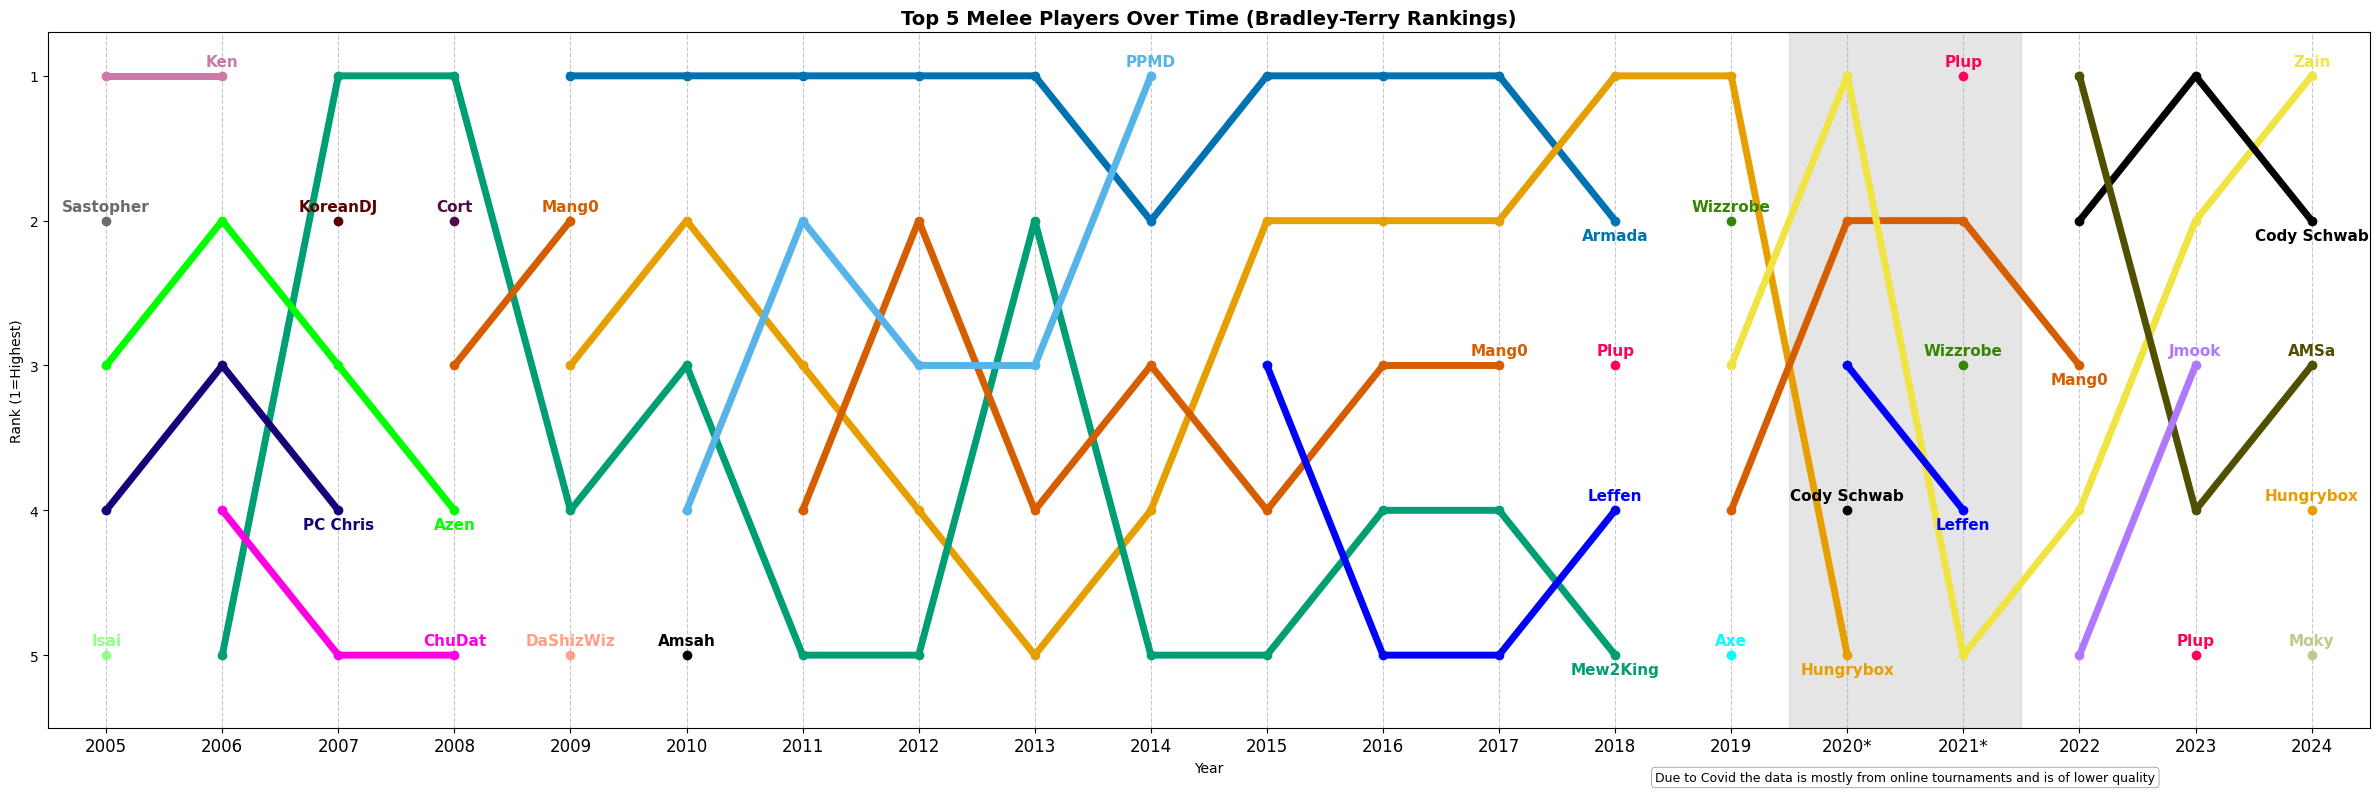

In [5]:
plot_melee_bump_chart(pd.concat(all_results, ignore_index=True))

### Comparison with Human Ranking Panels
In order to evaluate these rankings, we compare them to rankings produced by panels of human judges. [SSBMRank](https://liquipedia.net/smash/SSBMRank) has been released yearly since 2013 and is determined by compiling ranking ballots from top players and community figures. [RetroSSBMRank](https://liquipedia.net/smash/RetroSSBMRank) was a project to analyze the rankings from before SSBMRank was established and was compiled by Melee data analysts [Anokh "Edwin_Budding" Palakurthi](https://bignokh.com/) and [Michael "Pikachu942" Forde](https://x.com/gch_pikachu942).

In [6]:
# official rankings from SSBMRank and RetroSSBMRank
official_rankings = {
    2005: ["Ken", "ChuDat", "Isai", "Azen", "Sastopher"],
    2006: ["Ken", "Azen", "PC Chris", "ChuDat", "KoreanDJ"],
    2007: ["Mew2King", "Ken", "KoreanDJ", "PC Chris", "ChuDat"],
    2008: ["Mew2King", "Mang0", "Cort", "Azen", "PC Chris"],
    2009: ["Mang0", "Armada", "Hungrybox", "Mew2King", "DaShizWiz"],
    2010: ["Hungrybox", "Mang0", "Armada", "Mew2King", "PPMD"],
    2011: ["Armada", "Mang0", "PPMD", "Hungrybox", "Mew2King"],
    2012: ["Armada", "PPMD", "Mang0", "Hungrybox", "Mew2King"],
    2013: ["Mang0", "Armada", "Mew2King", "PPMD", "Hungrybox"],
    2014: ["Mang0", "Armada", "PPMD", "Mew2King", "Hungrybox"],
    2015: ["Armada", "Hungrybox", "Leffen", "Mang0", "Mew2King"],
    2016: ["Armada", "Hungrybox", "Mang0", "Mew2King", "Leffen"],
    2017: ["Hungrybox", "Armada", "Mang0", "Mew2King", "Plup"],
    2018: ["Hungrybox", "Armada", "Leffen", "Plup", "Mang0"],
    2019: ["Hungrybox", "Leffen", "Mang0", "Axe", "Wizzrobe"],
    2022: ["Zain", "AMSa", "Mang0", "Cody Schwab", "Hungrybox"],
    2023: ["Cody Schwab", "Zain", "Jmook", "Moky", "Plup"],
    2024: ["Zain", "Cody Schwab", "Mang0", "Moky", "Jmook"],
}

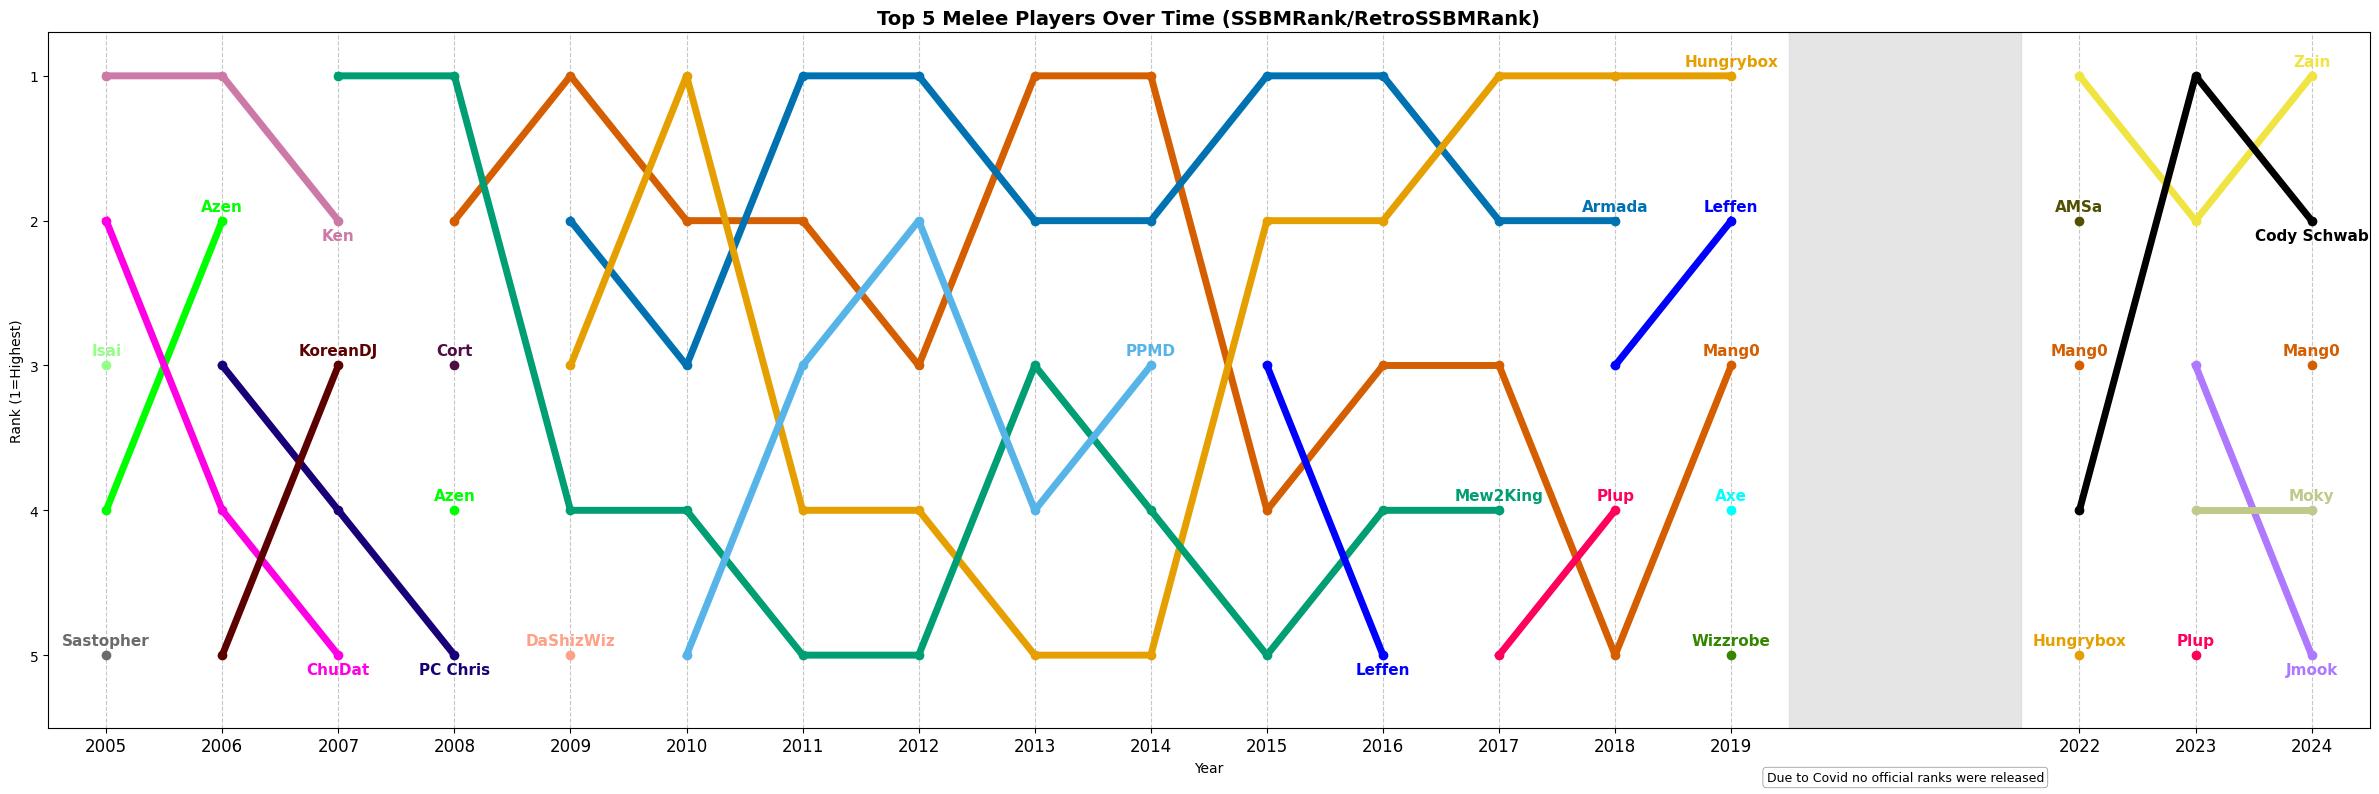

In [7]:
plot_melee_bump_chart(convert_ssbmrank_dict_to_plotting_df(official_rankings), message_type="official")

* For 12 out of 18 years with SSBMRank or RetroSSBMRank, the BT ranking agrees on the first place ranking! (2005, 2006, 2007, 2008, 2011, 2012, 2015, 2016, 2018, 2019, 2023, 2024)
* For some years like 2015 and 2016, the top 5 completely agree, and for 2023, 4/5 are in the same places.
* One player consistently rated higher by the human experts compared to the purely outcome-based ranking is Mango, who is a player known for being extremely good, but also for sandbagging and playing non-optimal characters on purpose and losing to lower ranked players. Often the ranking panelists will discount these results by saying "he wasn't really trying" but the Bradley-Terry model is not as forgiving and this cost him several years at #1.

It would be interesting to re-run these results, limited to the same list of major tournaments used by the official ranking panel and discounting events where top players are known to have "sandbagged." For now, this example is a proof of concept for data-driven rankings in esports, powered by the general-purpose Arena-Rank package!